<h3> Importing Libraries </h3>

In [132]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from pandas import *
import matplotlib.pyplot as plt
%matplotlib inline

<h3> Loading Data </h3>

In [133]:
positive_data = pd.read_fwf('positve_sample.txt', header=None, nrows=5000)
positive_data.columns = ["Gene"]
negative_data = pd.read_fwf('negative_sample.txt', header=None, nrows=5000)
negative_data.columns = ["Gene"]
data_ = pd.concat([positive_data, negative_data])

positive_test_data = pd.read_fwf('positive_sample_test.txt', header = None)
positive_test_data.columns = ["Gene"]
negative_test_data = pd.read_fwf('negative_sample_test.txt', header = None)
negative_test_data.columns = ["Gene"]
data_test = pd.concat([positive_test_data, negative_test_data])

In [134]:
def shuffle(df, n=1, axis=0):
    df = df.copy()
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
        return df

<h3> Hyperparameters </h3>

In [135]:
batch_size = 1
embedding_size = 10
window_size = 3
hidden_layer_size = 100
num_layers = 2
epochs = 200
lr = 0.01
fc_size = (len(positive_data.Gene[0]) - window_size + 1)*embedding_size
positives = positive_data.shape[0]
negatives = negative_data.shape[0]
print(fc_size)

990


<h3> Generating Vocabulary </h3>

In [136]:
vocab_set = set()
def generate_vocabmap_helper(set, k): 
    n = len(set)  
    generate_k_sized(set, "", n, k) 
def generate_k_sized(set, prefix, n, k): 
    if (k == 0) : 
        vocab_set.add(prefix)
        return
    for i in range(n): 
        newPrefix = prefix + set[i] 
        generate_k_sized(set, newPrefix, n, k - 1) 
def generate_vocabmap(n):
    alphabet = ['0','1','2','3','4']
    generate_vocabmap_helper(alphabet, n)
    
    vocab_set_1 = sorted(vocab_set)
    vocab_map = {}
    
    for i in range(len(vocab_set_1)):
        vocab_map[vocab_set_1[i]] = i
    return vocab_map

vocabulary = generate_vocabmap(window_size)
# print(vocabulary)

<h3> Generating Initial Embeddings </h3>

In [137]:
embeds = nn.Embedding(len(vocabulary), 5)
embeddings = {}
def generate_embeddings():
    for word in vocabulary:
        embeddings[word] = embeds(torch.tensor(vocabulary[word], dtype=torch.long)).type(torch.LongTensor)

generate_embeddings()

In [138]:
negative_labels = torch.zeros(negatives, 1)
positive_labels = torch.ones(positives, 1)
labels_ = torch.cat([positive_labels, negative_labels], dim=0)

<h3> Neural Network Implementation </h3>

In [139]:
def get_train_accuracy(label, index, data_size, correct, wrong):    
    if index < data_size/2+1:
        if label > 0.5:
            correct += 1
        else:
            wrong += 1
    else:
        if label > 0.5:
            wrong += 1
        else:
            correct += 1
    return correct, wrong

In [140]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embeds = nn.Embedding(len(vocabulary), embedding_size)
        self.fc1 = nn.Linear(fc_size, hidden_layer_size)
        self.relu1 = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu2 = nn.Sigmoid()
        self.out = nn.Linear(hidden_layer_size, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        z = self.embeds(x).view((1,-1))
        a1 = self.fc1(z)
        h1 = self.relu1(a1)
        a2 = self.fc2(h1)
        h2 = self.relu2(a2)
        
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
net = Net()


In [141]:
opt = optim.SGD(net.parameters(), lr, momentum=0.0)
criterion = nn.BCELoss()

In [142]:
def train_epoch(model, opt, criterion, batch_size=1):
    model.train()
    losses = []
    c = 0
    wrong, correct = 0, 0
    for data in data_.itertuples():
        data_batch = torch.tensor([vocabulary[data.Gene[i:i+window_size]] for i in range(0, len(data.Gene) - window_size + 1)], dtype=torch.long)
        labels_batch = labels_[c]
        c+=1
        data_batch = autograd.Variable(data_batch)
        labels_batch = autograd.Variable(labels_batch)

        opt.zero_grad()
        
        labels_hat = net(data_batch)
        loss = criterion(labels_hat, labels_batch)

        loss.backward()

        opt.step()        
        losses.append(loss.data.numpy())
        correct, wrong = get_train_accuracy(labels_hat, c, len(labels_), correct, wrong)
    loss = sum(losses)/len(losses)
    return loss,correct,wrong

In [143]:
def test_prediction_accuracy(labels):
    correct, wrong = 0, 0
    labels_hat = labels
    for i in range(len(labels_hat)//2 + 1):
        if labels_hat[i] > 0.5:
            correct += 1
        else:
            wrong += 1
    for i in range(101, len(labels_hat)):
        if labels_hat[i] > 0.5:
            wrong += 1
        else:
            correct += 1
    return (correct,wrong)

In [144]:
def test_prediction_model(data_test, labels_predicted):
    correct, wrong = 0, 0
    for data in data_test.itertuples():
        data_testing = torch.tensor([vocabulary[data.Gene[i:i+window_size]] for i in range(0, len(data.Gene) - window_size + 1)], dtype=torch.long)
        labels_hat = net(data_testing)
        labels_predicted.append(labels_hat[0])
    for i in range(len(labels_predicted)//2 + 1):
        if labels_predicted[i] > 0.5:
            correct += 1
        else:
            wrong += 1
    for i in range(101, len(labels_predicted)):
        if labels_predicted[i] > 0.5:
            wrong += 1
        else:
            correct += 1
    return correct,wrong

In [145]:
def load_test_model():
    model = Net()
    model.load_state_dict(torch.load('fc_with_lstm.pt'))
    model.eval()
    labels_predicted = []
    return test_prediction_model(data_test, labels_predicted)

Average Loss at epoch, 0 : 0.01577449934745091
Average Loss at epoch, 20 : 0.0075445951797680055
Average Loss at epoch, 40 : 0.007673680912818601
Average Loss at epoch, 60 : 0.004511700500715756
Average Loss at epoch, 80 : 0.0014076967831575416
Average Loss at epoch, 100 : 0.0005834348605423102
Average Loss at epoch, 120 : 0.00012988570572700268
Average Loss at epoch, 140 : 3.527943941596874e-05
Average Loss at epoch, 160 : 2.2110323947777034e-05
Average Loss at epoch, 180 : 1.6681355726704795e-05
88.0


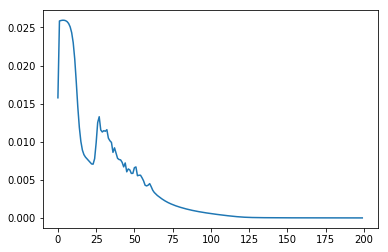

In [146]:
def train():
    losses = []
    accuracies = []
    test_acc = []
    for e in range(epochs):
        loss, c, w = train_epoch(net, opt, criterion, batch_size)
        accuracies.append(100*(c/(c+w)))
        losses.append(loss)
        if e % 20 == 0:
            print('Average Loss at epoch,',e,':',loss)
        torch.save(net.state_dict(), 'fc_with_lstm.pt')
        correct, wrong = load_test_model()
        test_acc.append(100*(correct/(correct+wrong)))
    print(test_acc[-1])
    plt.plot(losses)
    return accuracies, test_acc
train,test = train()

Text(0.5, 1.0, 'Test and Training Accuracies vs Epochs')

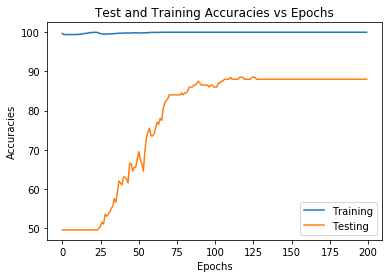

In [147]:
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.plot(train)
plt.plot(test)
plt.gca().legend(('Training', 'Testing'))
title = "Test and Training Accuracies vs Epochs"
plt.title(title)

In [148]:
from sklearn.utils import shuffle

positive_data = pd.read_fwf('positve_sample.txt', header=None, nrows=10)
positive_data.columns = ["Gene"]
print(positive_data["Gene"][9])
positive_data = shuffle(positive_data)
print(positive_data["Gene"][9])

44221412333131413242341422342422212311133132122231433143433121224422431441213424143422433423121224424
44221412333131413242341422342422212311133132122231433143433121224422431441213424143422433423121224424


In [149]:
def shuffle(df, n=1, axis=0):
    df = df.copy()
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
        return df
print(positive_data["Gene"][9])
positive_data=shuffle(positive_data)
print(positive_data["Gene"][9])


44221412333131413242341422342422212311133132122231433143433121224422431441213424143422433423121224424
31223333132431233223121422342131311343313443332423433234121123413243433123433333321224421223123422422
